# 💰 $100 Portfolio Experiment

In this notebook, we simulate a simple investment experiment.

The idea is straightforward:

If I had invested $100 seven years ago, how would it have behaved under different portfolio strategies?

We compare three approaches:

* 100% Global Market (VT)

* 100% Tech-Heavy Portfolio (QQQ)

* 50/50 Combination of Both

Using historical price data from Yahoo Finance (via the yfinance library), we will:

* Download adjusted closing prices

* Compute daily returns

* Simulate portfolio growth over time

* Measure performance using key metrics such as return, volatility, Sharpe ratio, and maximum drawdown

* Visualize growth, drawdowns, and rolling volatility

This experiment is not meant to predict future performance or provide investment advice.

It is a data-driven exploration of risk, diversification, and portfolio behavior.

# 🧪 Experiment Design

## 🎯 Goal

Compare stability vs growth using real historical data.

We contrast:

* 🌎 Global market exposure (more diversified, typically more stable)

* 💻 US tech tilt (more concentrated, typically more volatile)

The objective is to understand how different risk profiles behave over time.

## Step 1 — Pick the Assets (Tickers)

We use two ETFs:

🌎 VT - Global Market (Diversified)

* Vanguard Total World Stock ETF
* Buys thousands of companies
* Across many countries
* In one single fund

Represents broad global exposure.


💻 QQQ — US Tech-Heavy (Higher Risk)

* Tracks the Nasdaq-100 index
* Includes major companies such as:
    * Apple
    * Microsoft
    * Nvidia
    * Amazon
    * Meta
    * Other large tech-driven firms

Represents concentrated exposure to innovation and growth sectors.

## Step 2 — Define the Portfolios

We test three portfolios:

* Global only: 100% VT
* Tech only: 100% QQQ
* Balanced: 50% VT + 50% QQQ

Each portfolio starts with an initial investment of $100.

## Step 3 — Choose the Time Period

We use a fixed backtest window:

* Start date: 2019-01-01
* End date: Today
* Approximately the last 7 years

This period includes:

* Bull markets
* The 2020 COVID crash
* The 2022 downturn
* Recovery phases

This provides varied market conditions for analysis.

## Step 4 — Retrieve Price Data

We download Adjusted Close prices from Yahoo Finance (via the yfinance library).

Adjusted prices are used because they account for:

* Stock splits
* Dividends

We then convert prices into daily returns, which measure the percentage change from one day to the next.

## Step 5 — Simulate Portfolio Growth

For each portfolio:

* Start at $100
* Update the value daily based on portfolio returns
* Generate an equity curve (growth over time)

This shows how the investment evolves throughout the period.

## Step 6 — Compute Performance Metrics

For each portfolio, we calculate:

* Total Return — Final value relative to $100
* Annualized Return — Average yearly growth
* Volatility — How unstable the returns are
* Maximum Drawdown — Largest peak-to-trough decline
* Sharpe Ratio — Return per unit of risk

These metrics allow comparison beyond just final value.

## Step 7 — Visualize the Results

We generate:

📈 Growth curves (VT, QQQ, 50/50)

📉 Drawdown plot (visualizing worst declines)

📊 Rolling 30-day volatility (showing changing risk levels over time)

These visualizations help interpret performance behavior.

## Step 8 — Results Analysis

We evaluate:

* Which portfolio achieved the highest growth?
* Which portfolio was the most stable?
* Which experienced the deepest crash?
* Which aligns best with risk tolerance?

## Step 9 — Limitations

This experiment has important limitations:

* Past performance does not guarantee future results.
* No transaction costs or taxes are included.
* Results depend on the specific ETFs selected.
* The model assumes perfect discipline (buy-and-hold).
* Daily data and simplified assumptions are used.

/tmp/ipython-input-3669327715.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, progress=False)



=== Summary Metrics (Backtest) ===
           Portfolio  Ending Value ($)  Total Return (%)  Annualized Return (%)  Annualized Volatility (%)  Sharpe (rf=0%)  Max Drawdown (%)
    100% VT (Global)           259.183           163.290                 14.357                     18.721           0.811           -34.236
100% QQQ (Tech Tilt)           406.078           319.793                 21.823                     24.112           0.940           -35.119
        50/50 VT+QQQ           327.787           235.894                 18.202                     20.901           0.905           -31.049


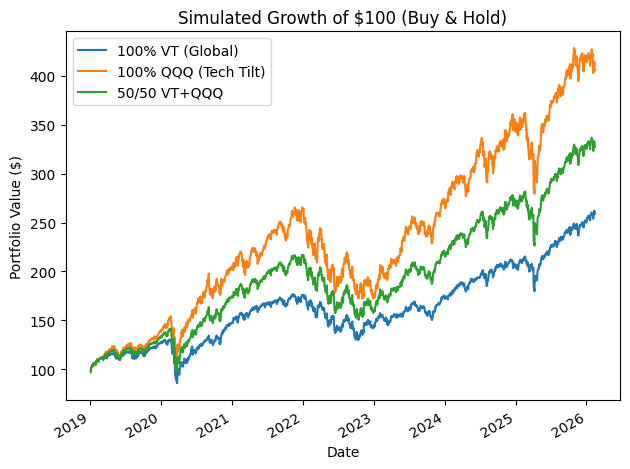

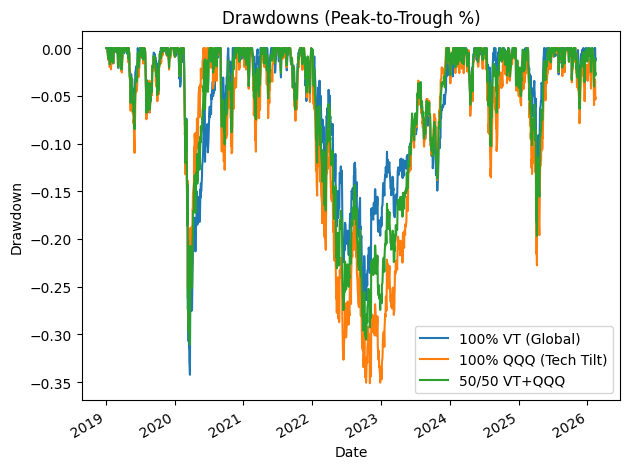

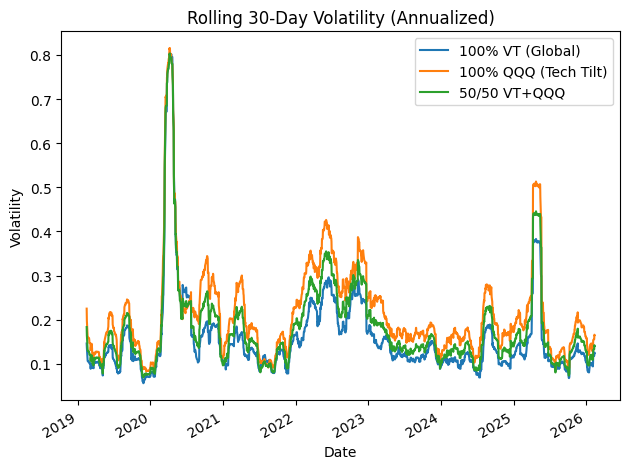

In [5]:
# $100 Portfolio Experiment: VT vs QQQ vs 50/50

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


def download_prices(tickers, start="2019-01-01"):
    """
    Downloads adjusted close prices for tickers from Yahoo Finance.
    """
    df = yf.download(tickers, start=start, progress=False)
    if "Close" not in df.columns:
        raise ValueError("Could not find 'Close' in downloaded data.")
    prices = df["Close"].dropna(how="all")
    prices = prices.dropna()  # ensure aligned dates across tickers
    return prices


def compute_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Computes daily simple returns from price series.
    """
    rets = prices.pct_change().dropna()
    return rets


def equity_curve(returns: pd.Series, initial_value=100.0) -> pd.Series:
    """
    Converts daily returns into an equity curve starting at initial_value.
    """
    return initial_value * (1.0 + returns).cumprod()


def max_drawdown(equity: pd.Series) -> float:
    """
    Maximum drawdown (most negative drawdown) of an equity curve.
    """
    peak = equity.cummax()
    dd = equity / peak - 1.0
    return float(dd.min())


def annualized_return(daily_returns: pd.Series, trading_days=252) -> float:
    """
    Annualized return using geometric mean.
    """
    # geometric mean daily growth
    growth = (1.0 + daily_returns).prod()
    n_days = daily_returns.shape[0]
    if n_days == 0:
        return np.nan
    return float(growth ** (trading_days / n_days) - 1.0)


def annualized_volatility(daily_returns: pd.Series, trading_days=252) -> float:
    """
    Annualized volatility from daily standard deviation.
    """
    return float(daily_returns.std(ddof=1) * np.sqrt(trading_days))


def sharpe_ratio(daily_returns: pd.Series, risk_free_annual=0.0, trading_days=252) -> float:
    """
    Sharpe ratio with an annual risk-free rate (default 0%).
    Converts annual RF to daily RF approximately.
    """
    rf_daily = (1.0 + risk_free_annual) ** (1.0 / trading_days) - 1.0
    excess = daily_returns - rf_daily
    vol = excess.std(ddof=1)
    if vol == 0:
        return np.nan
    return float((excess.mean() / vol) * np.sqrt(trading_days))


def portfolio_returns(returns_df: pd.DataFrame, weights: dict) -> pd.Series:
    """
    Creates portfolio daily returns from asset returns and weights.
    weights example: {"VT": 0.5, "QQQ": 0.5}
    """
    # Ensure all tickers exist in returns_df
    for t in weights:
        if t not in returns_df.columns:
            raise ValueError(f"Ticker {t} not found in returns data columns.")

    w = pd.Series(weights).reindex(returns_df.columns).fillna(0.0)
    # Weighted sum of daily returns
    return returns_df.mul(w, axis=1).sum(axis=1)


def summarize(name: str, daily_rets: pd.Series, equity: pd.Series):
    """
    Returns a dict of summary metrics for easy table printing.
    """
    return {
        "Portfolio": name,
        "Total Return (%)": (equity.iloc[-1] / equity.iloc[0] - 1.0) * 100.0,
        "Annualized Return (%)": annualized_return(daily_rets) * 100.0,
        "Annualized Volatility (%)": annualized_volatility(daily_rets) * 100.0,
        "Sharpe (rf=0%)": sharpe_ratio(daily_rets, risk_free_annual=0.0),
        "Max Drawdown (%)": max_drawdown(equity) * 100.0,
        "Ending Value ($)": float(equity.iloc[-1]),
    }


def main():
    tickers = ["VT", "QQQ"]
    start_date = "2019-01-01"
    initial_value = 100.0

    # 1) Download prices
    prices = download_prices(tickers, start=start_date)

    # 2) Compute daily returns
    rets = compute_returns(prices)

    # 3) Build portfolio daily returns
    rets_vt = portfolio_returns(rets, {"VT": 1.0})
    rets_qqq = portfolio_returns(rets, {"QQQ": 1.0})
    rets_5050 = portfolio_returns(rets, {"VT": 0.5, "QQQ": 0.5})

    # 4) Equity curves
    eq_vt = equity_curve(rets_vt, initial_value)
    eq_qqq = equity_curve(rets_qqq, initial_value)
    eq_5050 = equity_curve(rets_5050, initial_value)

    # 5) Summary table
    summary = pd.DataFrame([
        summarize("100% VT (Global)", rets_vt, eq_vt),
        summarize("100% QQQ (Tech Tilt)", rets_qqq, eq_qqq),
        summarize("50/50 VT+QQQ", rets_5050, eq_5050),
    ])

    # Pretty printing
    pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
    print("\n=== Summary Metrics (Backtest) ===")
    print(summary[[
        "Portfolio",
        "Ending Value ($)",
        "Total Return (%)",
        "Annualized Return (%)",
        "Annualized Volatility (%)",
        "Sharpe (rf=0%)",
        "Max Drawdown (%)",
    ]].to_string(index=False))

    # 6) Plots: growth
    growth_df = pd.DataFrame({
        "100% VT (Global)": eq_vt,
        "100% QQQ (Tech Tilt)": eq_qqq,
        "50/50 VT+QQQ": eq_5050,
    })

    plt.figure()
    growth_df.plot(ax=plt.gca())
    plt.title("Simulated Growth of $100 (Buy & Hold)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.tight_layout()
    plt.show()

    # 7) Plots: drawdowns
    def drawdown_series(equity: pd.Series) -> pd.Series:
        peak = equity.cummax()
        return equity / peak - 1.0

    dd_df = pd.DataFrame({
        "100% VT (Global)": drawdown_series(eq_vt),
        "100% QQQ (Tech Tilt)": drawdown_series(eq_qqq),
        "50/50 VT+QQQ": drawdown_series(eq_5050),
    })

    plt.figure()
    dd_df.plot(ax=plt.gca())
    plt.title("Drawdowns (Peak-to-Trough %)")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.tight_layout()
    plt.show()

    # 8) Plot: rolling 30-day volatility (annualized)
    window = 30
    roll_vol = pd.DataFrame({
        "100% VT (Global)": rets_vt.rolling(window).std(ddof=1) * np.sqrt(252),
        "100% QQQ (Tech Tilt)": rets_qqq.rolling(window).std(ddof=1) * np.sqrt(252),
        "50/50 VT+QQQ": rets_5050.rolling(window).std(ddof=1) * np.sqrt(252),
    }).dropna()

    plt.figure()
    roll_vol.plot(ax=plt.gca())
    plt.title(f"Rolling {window}-Day Volatility (Annualized)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


# 📊 Results

After simulating the three portfolios from January 1, 2019 to the present, several clear patterns emerge.

## 📈 Growth

The tech-heavy portfolio (100% QQQ) produced the highest final value. It significantly outperformed the global portfolio (100% VT) in terms of total return over the full period.

The balanced 50/50 portfolio fell between the two, capturing part of the tech upside while maintaining broader diversification.

From a pure growth perspective:

* QQQ > 50/50 Portfolio > VT

However, growth alone does not tell the full story.

## 📉 Volatility and Stability

QQQ exhibited noticeably higher volatility throughout the period. Its daily fluctuations were larger, and rolling volatility spikes were more pronounced during periods of market stress.

VT demonstrated lower volatility, reflecting its broader global diversification.

The 50/50 portfolio consistently reduced volatility compared to QQQ, confirming the stabilizing effect of diversification.

## ⚠️ Maximum Drawdown

The drawdown analysis highlights the emotional cost of concentration.

During market downturns (notably 2020 and 2022), QQQ experienced the deepest peak-to-trough declines. These drops were significantly larger than those of VT.

The balanced portfolio reduced drawdown severity compared to QQQ, though it did not eliminate it entirely.

This reinforces an important observation:

Higher returns came with deeper interim losses.

## 📐 Risk-Adjusted Performance

When considering the Sharpe ratio (return per unit of risk), the comparison becomes more nuanced.

Although QQQ delivered the highest return, its higher volatility reduces its risk-adjusted advantage.

The balanced portfolio often provides a compelling middle ground — offering improved risk-adjusted performance relative to pure concentration.

## 🔎 Key Takeaway

This experiment confirms the fundamental trade-off in portfolio construction:

* Concentration increases both upside and downside.
* Diversification smooths extremes.
* The “best” portfolio depends on risk tolerance.

From a purely numerical standpoint, QQQ led in growth.

From a stability perspective, VT offered a smoother ride.

The 50/50 portfolio demonstrated how combining exposures can meaningfully reduce risk while still participating in growth.

## 👤 Author

Basak Kaya

MEng Student, Mechanical & Industrial Engineering

University of Toronto